## Residual dependence on host galaxy types & Inclination

### Load Data

In [1]:
import pickle
max_dist_arcsec = 1.0
with open("./post_data/valid_host_galaxies.pkl","rb") as f:
    data = pickle.load(f)

SN_sample = data["SN_sample"]
valid_SN_ids = data["valid_SN_ids"]
valid_host_galaxies = data["valid_host_galaxies"]

### Setup Cosmology

In [2]:
# cosmology
import numpy as np
import scipy.constants as const
from scipy.integrate import quad


def E_Flat_LCDM(z, Omega_m):
    """Flat ΛCDM: E(z) function."""
    return np.sqrt(Omega_m * (1 + z) ** 3 + (1 - Omega_m))


def E_Open_LCDM(z, Omega_m, Omega_k):
    """Open ΛCDM: E(z) function."""
    Omega_Lambda = 1 - Omega_m - Omega_k
    return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)


def E_Flat_wCDM(z, Omega_m, w):
    """Flat wCDM: E(z) function."""
    return np.sqrt(Omega_m * (1 + z) ** 3 + (1 - Omega_m) * (1 + z) ** (3 * (1 + w)))


def E_Flat_w0waCDM(z, Omega_m, w0, wa):
    """
    Flat w0waCDM: E(z) function. Using CPL paramerization: w(z) = w0 + wa * z/(1+z).
    """
    Omega_DE = 1 - Omega_m
    return np.sqrt(
        Omega_m * (1 + z) ** 3
        + Omega_DE * (1 + z) ** (3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    )


def luminosity_distance_Flat_LCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat ΛCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m = params[0]
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_LCDM(z_prime, Omega_m)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def luminosity_distance_Open_LCDM(z, params, H0=70.0):
    """
    Distance Modulus for Open ΛCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                Omega_k: Curvature density parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, Omega_k = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Open_LCDM(z_prime, Omega_m, Omega_k)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)
    dC *= dH

    # Comoving transverse distance
    if Omega_k == 0:
        dM = dC
    elif Omega_k > 0:
        dM = dH / np.sqrt(Omega_k) * np.sinh(np.sqrt(Omega_k) * dC / dH)  # 开放
    else:
        dM = dH / np.sqrt(-Omega_k) * np.sin(np.sqrt(-Omega_k) * dC / dH)  # 闭合

    return (1 + z) * dM


def luminosity_distance_Flat_wCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat wCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                w: Dark energy equation of state parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, w = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_wCDM(z_prime, Omega_m, w)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def luminosity_distance_Flat_w0waCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat w0waCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                w0: Dark energy equation of state parameter at z=0
                wa: Evolution parameter of dark energy equation of state
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, w0, wa = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_w0waCDM(z_prime, Omega_m, w0, wa)

    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def distance_modulus(z, params, model="Flat_LCDM"):
    """
    Distance modulus for various cosmological models.

    Parameters:
        z: Redshift
        params: Model parameters (tuple)
        model: Cosmological model. Options: "Flat_LCDM", "Open_LCDM", "Flat_wCDM", "Flat_w0waCDM"
    Returns:
        Distance Modulus (mu)
    """
    model_funcs = {
        "Flat_LCDM": luminosity_distance_Flat_LCDM,
        "Open_LCDM": luminosity_distance_Open_LCDM,
        "Flat_wCDM": luminosity_distance_Flat_wCDM,
        "Flat_w0waCDM": luminosity_distance_Flat_w0waCDM,
    }

    if model not in model_funcs:
        raise ValueError(f"Invalid model: {model}. Valid models: {list(model_funcs.keys())}")

    dL = model_funcs[model](z, params, H0=70.0)

    return 5 * np.log10(dL / 10) + 25

Omega_m = 0.3289 +0.0152 -0.0143
M       = 5.0081 +0.0099 -0.0103


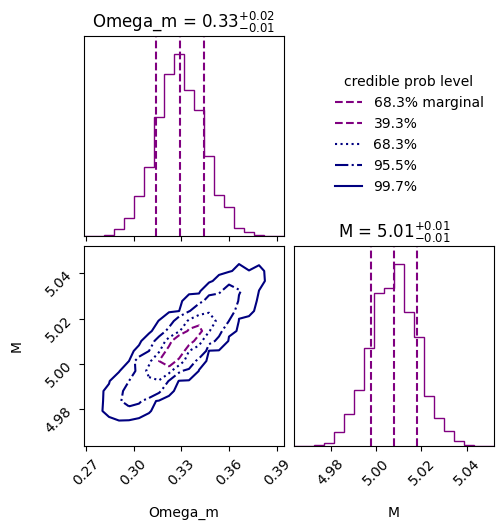

In [3]:
# analysis with FLCDM
from ultranest.plot import cornerplot
from ultranest.utils import resample_equal

with open(f'fits/Flat_LCDM_wide_result.pkl', 'rb') as f:
    Flat_LCDM_result = pickle.load(f)

cornerplot(Flat_LCDM_result)

# Extract weighted posterior
samples   = Flat_LCDM_result["weighted_samples"]["points"]
weights   = Flat_LCDM_result["weighted_samples"]["weights"]

# Resample to get equal-weighted posterior
equal_samples = resample_equal(samples, weights / np.sum(weights))

# compute median and 16/84 percentiles
Omega_m_q16, Omega_m_q50, Omega_m_q84 = np.percentile(equal_samples[:, 0], [16, 50, 84])
M_q16,       M_q50,       M_q84       = np.percentile(equal_samples[:, 1], [16, 50, 84])

print(f"Omega_m = {Omega_m_q50:.4f} +{Omega_m_q84 - Omega_m_q50:.4f} "
      f"-{Omega_m_q50 - Omega_m_q16:.4f}")
print(f"M       = {M_q50:.4f} +{M_q84 - M_q50:.4f} "
      f"-{M_q50 - M_q16:.4f}")

### Residual Analysis

In [4]:
def flux_to_w1mag(flux_w1):
    """
    Convert WISE W1 flux (nanomaggies) to AB magnitude.
    Legacy Survey convention:
        m = 22.5 - 2.5 * log10(flux)
    """
    if flux_w1 <= 0 or np.isnan(flux_w1):
        return np.nan
    return 22.5 - 2.5 * np.log10(flux_w1)

z_all = SN_sample['zHD'].data
mu_obs_all = SN_sample['MU'].data

# Model distance modulus for Flat ΛCDM
mu_model_all = np.array([
    distance_modulus(z, [Omega_m_q50], model='Flat_LCDM') + M_q50
    for z in z_all
])

# Hubble residuals: Δμ = μ_obs − μ_model
residual_all = mu_obs_all - mu_model_all

#### Type Analysis

In [5]:
# 提取所有宿主星系的type分类
all_types = []

for host in valid_host_galaxies:
    if 'type' in host.colnames:
        host_type = host['type'][0]
        if isinstance(host_type, str):
            host_type = host_type.strip()
        all_types.append(host_type)
    else:
        all_types.append('Unknown')

all_types = np.array(all_types)

unique_types, counts = np.unique(all_types, return_counts=True)
print("\n各类星系形态统计:")
for host_type, count in zip(unique_types, counts):
    print(f"{host_type}: {count} 个 ({count/len(all_types)*100:.1f}%)")


各类星系形态统计:
DEV: 145 个 (12.1%)
EXP: 231 个 (19.3%)
REX: 503 个 (42.1%)
SER: 317 个 (26.5%)


EXP: N=196, slope=0.0122±0.1106
DEV: N=139, slope=0.0380±0.1955
SER: N=307, slope=0.0238±0.1546
REX: N=449, slope=0.0047±0.0687


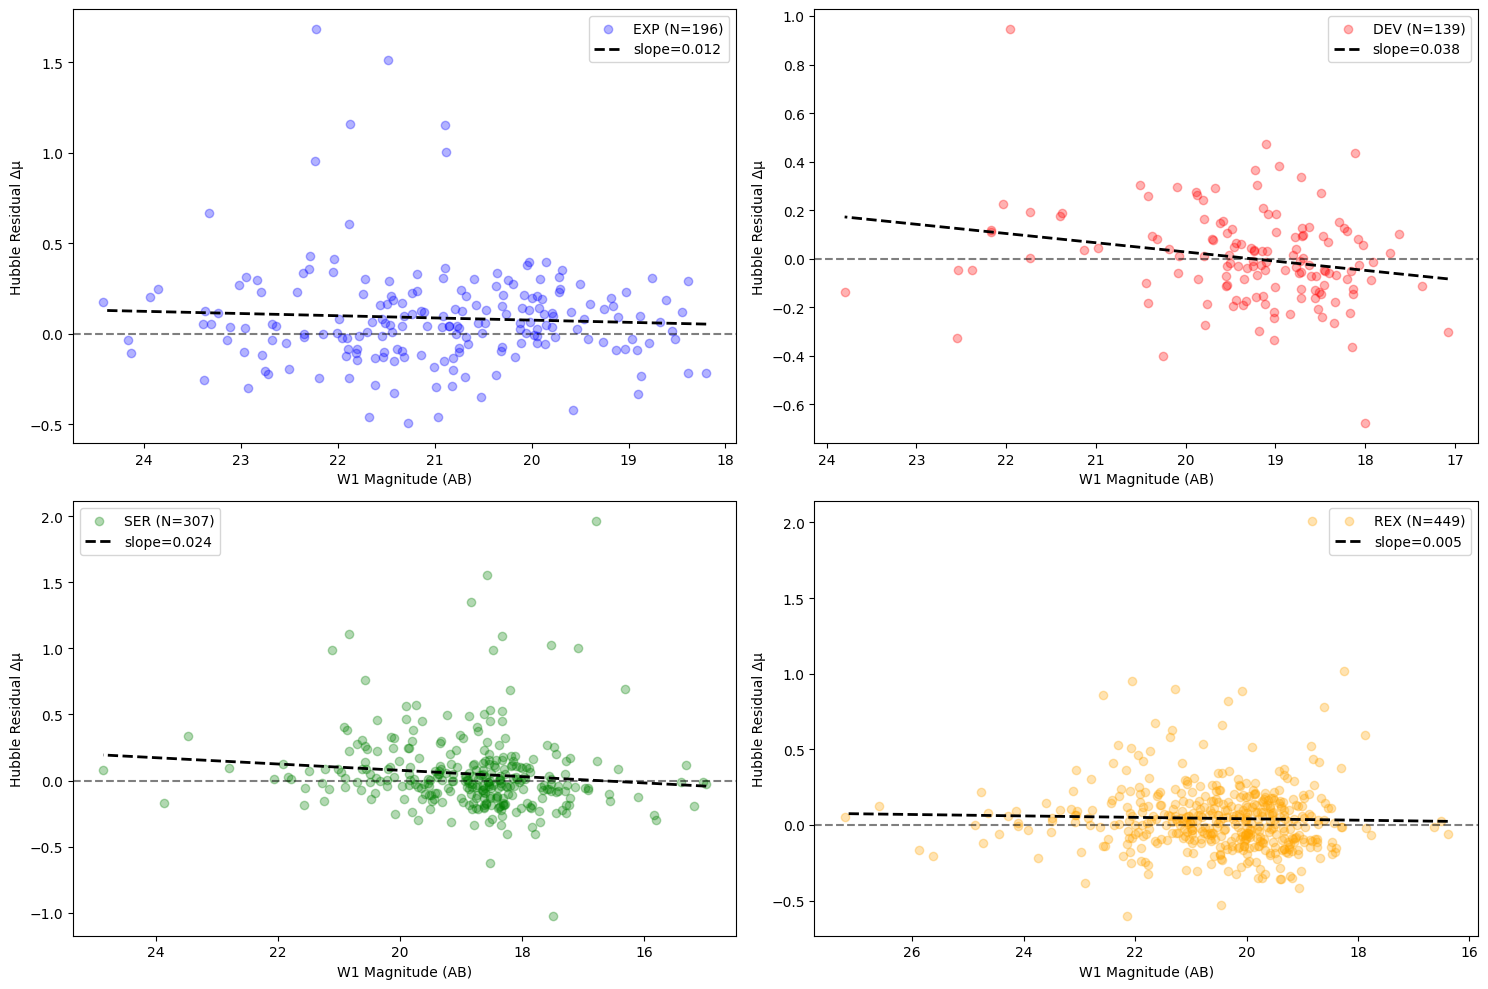

In [7]:
# 按type分类分析
import matplotlib.pyplot as plt

types_to_analyze = ['EXP', 'DEV', 'SER', 'REX']
type_results = {}

for galaxy_type in types_to_analyze:
    # 筛选当前类型的星系
    type_w1 = []
    type_residuals = []
    type_sn_ids = []
    
    for i, host in enumerate(valid_host_galaxies):
        if 'type' not in host.colnames:
            continue
            
        host_type = host['type'][0]
        if isinstance(host_type, str):
            host_type = host_type.strip()
        
        if host_type == galaxy_type and 'flux_w1' in host.colnames:
            SN_id = host['ID'][0]
            flux_w1 = host['flux_w1'][0]
            w1_mag = flux_to_w1mag(flux_w1)
            
            if not np.isnan(w1_mag):
                type_w1.append(w1_mag)
                type_residuals.append(residual_all[SN_id])
                type_sn_ids.append(SN_id)
    
    if len(type_w1) > 5:  # 确保有足够的数据点进行拟合
        type_w1 = np.array(type_w1)
        type_residuals = np.array(type_residuals)
        
        # 线性拟合
        coef = np.polyfit(type_w1, type_residuals, 1)
        slope, intercept = coef
        slope_err = np.sqrt(np.cov(type_w1, type_residuals)[0,1] / np.var(type_w1)) if len(type_w1) > 1 else 0
        
        type_results[galaxy_type] = {
            'count': len(type_w1),
            'slope': slope,
            'slope_err': slope_err,
            'intercept': intercept,
            'W1_mean': np.mean(type_w1),
            'residual_mean': np.mean(type_residuals)
        }
        
        print(f"{galaxy_type}: N={len(type_w1)}, slope={slope:.4f}±{slope_err:.4f}")

# 绘制分类结果
plt.figure(figsize=(15, 10))
colors = {'EXP': 'blue', 'DEV': 'red', 'SER': 'green', 'REX': 'orange'}

for i, galaxy_type in enumerate(types_to_analyze):
    if galaxy_type not in type_results:
        continue
        
    # 筛选数据
    type_w1 = []
    type_residuals = []
    
    for host in valid_host_galaxies:
        if 'type' not in host.colnames:
            continue
        host_type = host['type'][0]
        if isinstance(host_type, str):
            host_type = host_type.strip()
        
        if host_type == galaxy_type and 'flux_w1' in host.colnames:
            SN_id = host['ID'][0]
            flux_w1 = host['flux_w1'][0]
            w1_mag = flux_to_w1mag(flux_w1)
            if not np.isnan(w1_mag):
                type_w1.append(w1_mag)
                type_residuals.append(residual_all[SN_id])
    
    type_w1 = np.array(type_w1)
    type_residuals = np.array(type_residuals)
    
    plt.subplot(2, 2, i+1)
    plt.scatter(type_w1, type_residuals, alpha=0.3, color=colors[galaxy_type], 
                label=f'{galaxy_type} (N={len(type_w1)})')
    
    # 拟合线
    if len(type_w1) > 1:
        coef = np.polyfit(type_w1, type_residuals, 1)
        xfit = np.linspace(type_w1.min(), type_w1.max(), 100)
        yfit = coef[0] * xfit + coef[1]
        plt.plot(xfit, yfit, 'k--', linewidth=2, 
                label=f'slope={coef[0]:.3f}')
    
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)
    plt.xlabel('W1 Magnitude (AB)')
    plt.ylabel('Hubble Residual Δμ')
    plt.gca().invert_xaxis()
    plt.legend()

plt.tight_layout()
plt.show()

DEV (DEV): N=139, slope=0.0380±0.0166, correlation=0.221, W1_mean=19.31
Other (EXP, SER, REX): N=952, slope=0.0105±0.0033, correlation=0.064, W1_mean=20.07


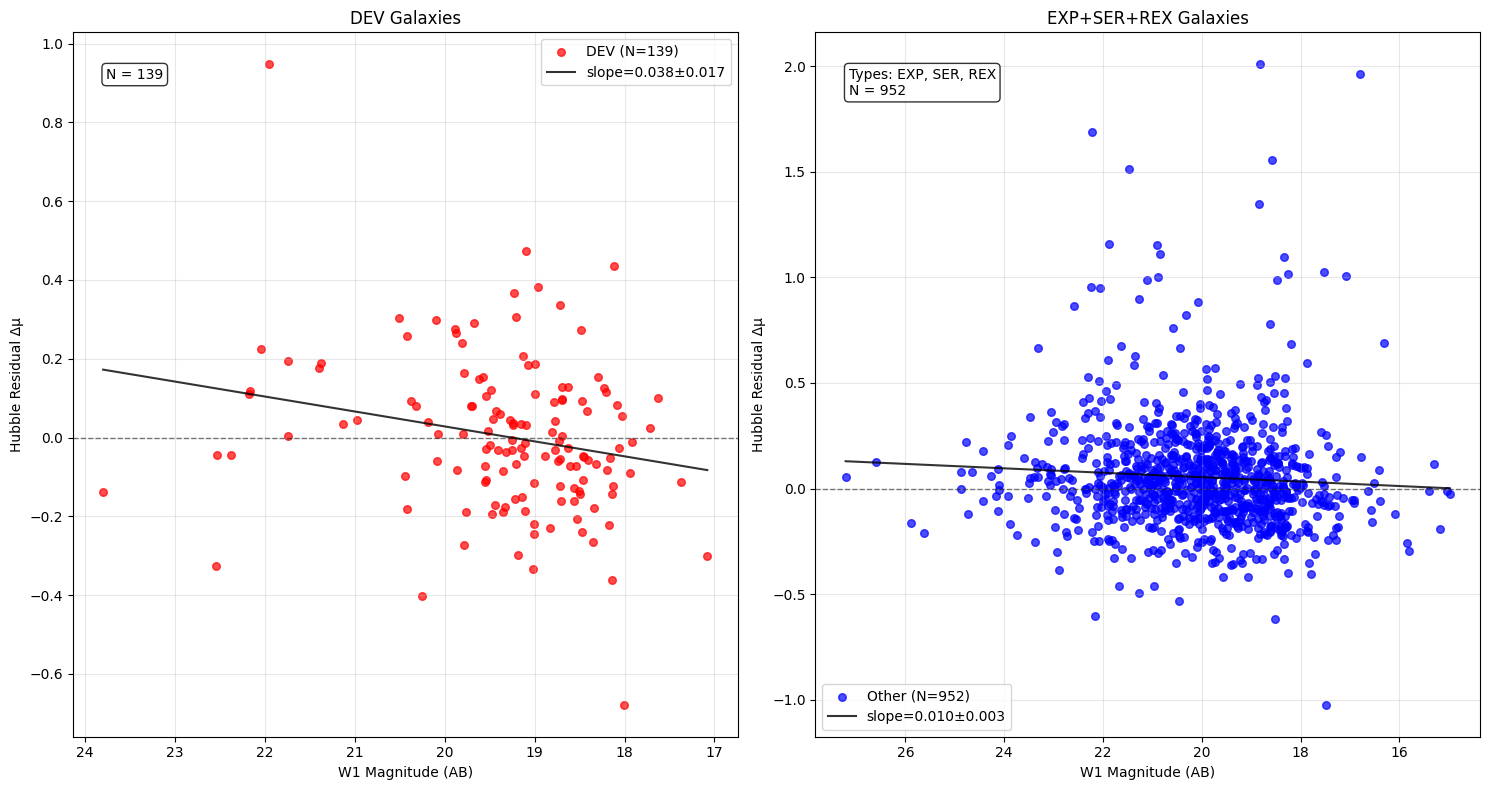

In [8]:
# 将DEV单独列出，其他类型合并为"Other"
type_results = {}
type_groups = {'DEV': ['DEV'], 'Other': ['EXP', 'SER', 'REX']}

colors = {'DEV': 'red', 'Other': 'blue'}

plt.figure(figsize=(15, 8))

for i, (group_name, type_list) in enumerate(type_groups.items()):
    group_w1 = []
    group_residuals = []
    group_sn_ids = []
    
    for host in valid_host_galaxies:
        if 'type' not in host.colnames:
            continue
            
        host_type = host['type'][0]
        if isinstance(host_type, str):
            host_type = host_type.strip()
        
        # 如果主机类型在当前组的类型列表中
        if host_type in type_list and 'flux_w1' in host.colnames:
            SN_id = host['ID'][0]
            flux_w1 = host['flux_w1'][0]
            w1_mag = flux_to_w1mag(flux_w1)
            
            if not np.isnan(w1_mag):
                group_w1.append(w1_mag)
                group_residuals.append(residual_all[SN_id])
                group_sn_ids.append(SN_id)
    
    if len(group_w1) > 5:  # 确保有足够的数据点进行拟合
        group_w1 = np.array(group_w1)
        group_residuals = np.array(group_residuals)
        
        # 线性拟合
        coef = np.polyfit(group_w1, group_residuals, 1)
        slope, intercept = coef
        
        # 计算斜率误差
        if len(group_w1) > 1:
            cov_matrix = np.cov(group_w1, group_residuals)
            if cov_matrix.shape == (2, 2):
                slope_err = np.sqrt(np.abs(cov_matrix[0,1]) / np.var(group_w1)) / np.sqrt(len(group_w1)-1)
            else:
                slope_err = 0
        else:
            slope_err = 0
        
        # 计算相关系数
        if len(group_w1) > 1:
            correlation = np.corrcoef(group_w1, group_residuals)[0,1]
        else:
            correlation = 0
        
        type_results[group_name] = {
            'count': len(group_w1),
            'slope': slope,
            'slope_err': slope_err,
            'intercept': intercept,
            'W1_mean': np.mean(group_w1),
            'residual_mean': np.mean(group_residuals),
            'correlation': correlation,
            'types': type_list
        }
        
        types_str = ', '.join(type_list) if group_name != 'DEV' else 'DEV'
        print(f"{group_name} ({types_str}): N={len(group_w1)}, slope={slope:.4f}±{slope_err:.4f}, "
              f"correlation={correlation:.3f}, W1_mean={np.mean(group_w1):.2f}")
        
        plt.subplot(1, 2, i+1)
        plt.scatter(group_w1, group_residuals, alpha=0.7, color=colors[group_name], 
                    label=f'{group_name} (N={len(group_w1)})', s=30)
        
        # 绘制拟合线
        xfit = np.linspace(group_w1.min(), group_w1.max(), 100)
        yfit = slope * xfit + intercept
        plt.plot(xfit, yfit, 'k-', linewidth=1.5, alpha=0.8,
                label=f'slope={slope:.3f}±{slope_err:.3f}')
        plt.axhline(0, color='k', linestyle='--', alpha=0.5, linewidth=1)
        
        plt.xlabel('W1 Magnitude (AB)')
        plt.ylabel('Hubble Residual Δμ')
        plt.gca().invert_xaxis()
        
        if group_name == 'Other':
            plt.title(f'EXP+SER+REX Galaxies')
        else:
            plt.title(f'{group_name} Galaxies')
        
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        if group_name == 'DEV':
            plt.text(0.05, 0.95, f'N = {len(group_w1)}', 
                     transform=plt.gca().transAxes, fontsize=10,
                     verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        else:
            plt.text(0.05, 0.95, f'Types: EXP, SER, REX\nN = {len(group_w1)}', 
                     transform=plt.gca().transAxes, fontsize=10,
                     verticalalignment='top',
                     bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

#### Inclination Analysis

In [9]:
from scipy import stats

def compare_type_slopes(type_results, type1='DEV', type2='Other'):
    """
    检验两个类型的斜率是否有显著差异
    """
    # 获取斜率和标准误差
    slope1 = type_results[type1]['slope']
    slope_err1 = type_results[type1]['slope_err']
    n1 = type_results[type1]['count']
    
    slope2 = type_results[type2]['slope']
    slope_err2 = type_results[type2]['slope_err']
    n2 = type_results[type2]['count']
    
    # 计算斜率差异
    slope_diff = slope1 - slope2
    slope_diff_se = np.sqrt(slope_err1**2 + slope_err2**2)
    
    # t检验
    t_stat = slope_diff / slope_diff_se
    df = n1 + n2 - 4  # 自由度 = 总样本数 - 4 (两个斜率，两个截距)
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df))
    
    print(f"=== {type1} vs {type2} ===")
    print(f"{type1}: slope = {slope1:.4f} ± {slope_err1:.4f}, N = {n1}")
    print(f"{type2}: slope = {slope2:.4f} ± {slope_err2:.4f}, N = {n2}")
    print(f"slope difference: {slope_diff:.4f} ± {slope_diff_se:.4f}")
    print(f"t: {t_stat:.3f}")
    print(f"p: {p_value:.4f}")
    
    if p_value < 0.05:
        print(f"\n95% confidence level: no significant difference in the slopes between {type1} and {type2}. (p = {p_value:.4f})")
    else:
        print(f"\n95% confidence level: significant difference in the slopes between {type1} and {type2}. (p = {p_value:.4f})")
    
    return t_stat, p_value

t_stat, p_value = compare_type_slopes(type_results, 'DEV', 'Other')

=== DEV vs Other ===
DEV: slope = 0.0380 ± 0.0166, N = 139
Other: slope = 0.0105 ± 0.0033, N = 952
slope difference: 0.0275 ± 0.0170
t: 1.620
p: 0.1056

95% confidence level: significant difference in the slopes between DEV and Other. (p = 0.1056)


In [10]:
SN_ids = []
W1_mag = []
residuals = []

for host in valid_host_galaxies:
    SN_id = host['ID'][0]
    SN_ids.append(SN_id)
    residuals.append(residual_all[SN_id])

SN_ids = np.array(SN_ids)
residuals = np.array(residuals)


--- Basic Statistics ---
Inclination range: 0.0° to 78.8°
Mean inclination: 26.7° ± 24.9°
Mean Hubble residual: 0.049 mag ± 0.263 mag

--- Correlation Analysis ---
Pearson correlation coefficient: r = 0.065
p-value: p = 2.430e-02
Significance: 2.3σ
Linear relation: Δμ = (0.0007 ± 0.0003) × inclination + (0.031)
R² = 0.004


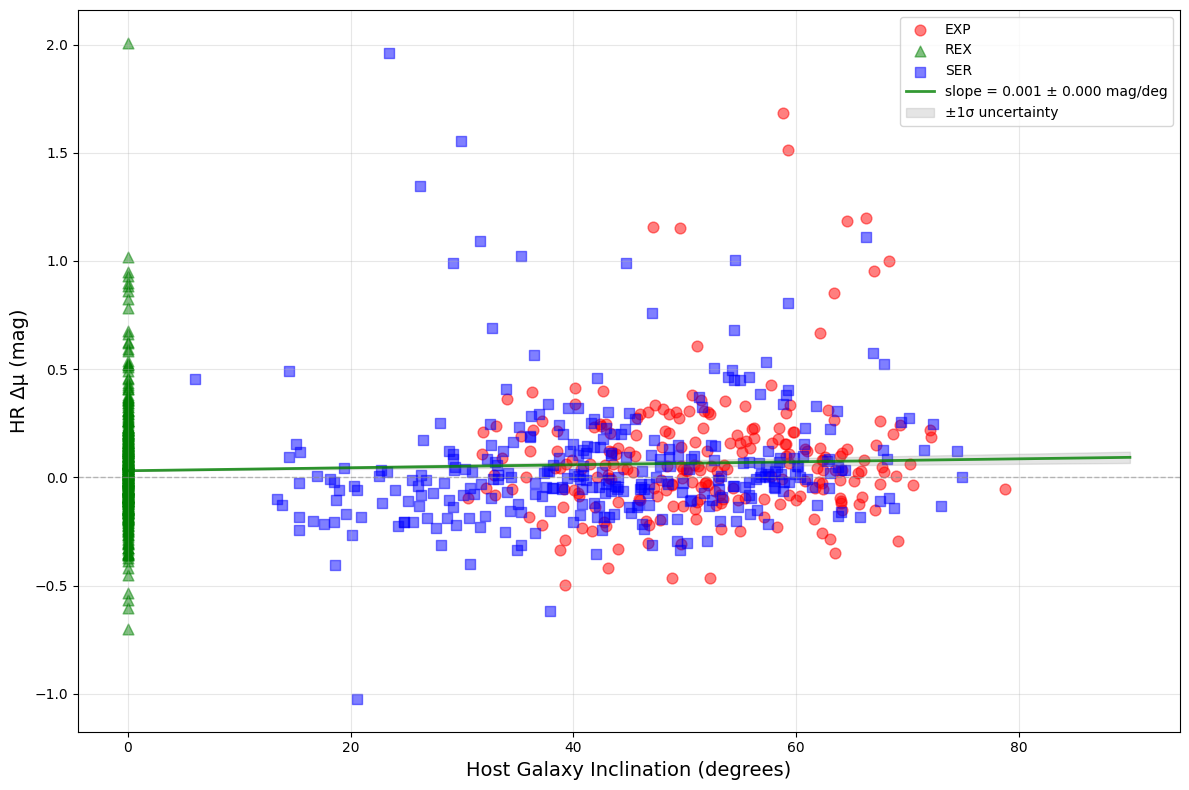

In [11]:
from scipy.stats import pearsonr
from scipy.optimize import curve_fit

def calculate_inclination_from_shape(shape_e1, shape_e2, host_type):
    """
    Calculate galaxy inclination from shape parameters using Kelly et al. (2010) method
    Only applicable to disk galaxies (EXP, SER, REX)
    
    Parameters:
    -----------
    shape_e1, shape_e2 : float
        Ellipticity components from shape measurement
    host_type : str
        Galaxy type (EXP, SER, REX for disk galaxies)
    
    Returns:
    --------
    inclination_deg : float
        Inclination angle in degrees, or NaN for non-disk galaxies
    """
    disk_galaxies = ['EXP', 'SER']
    
    e = np.sqrt(shape_e1**2 + shape_e2**2)
    
    # Validate ellipticity range
    if e >= 1 or e < 0 or np.isnan(e):
        return np.nan
    
    # Calculate axis ratio q = b/a, then inclination i = arccos(q)
    q = 1 - e  # Simplified assumption for thin disk
    
    # Validate axis ratio
    if q <= 0 or q > 1:
        return np.nan
    
    # Calculate inclination in radians and convert to degrees
    inclination_rad = np.arccos(q)
    inclination_deg = np.degrees(inclination_rad)
    
    return inclination_deg

def linear_model(x, a, b):
    return a * x + b

def calculate_correlation_statistics(x, y, x_err=None, y_err=None):
    """
    Calculate comprehensive correlation statistics
    
    Returns:
    --------
    dict : Dictionary containing correlation statistics
    """
    n = len(x)
    
    # Pearson correlation
    r, p_value = pearsonr(x, y)
    
    # Linear fit with error weighting if provided
    if x_err is not None and y_err is not None:
        try:
            # Effective uncertainty for fitting
            sigma_eff = np.sqrt(x_err**2 + y_err**2) if x_err is not None and y_err is not None else None
            
            popt, pcov = curve_fit(linear_model, x, y, sigma=sigma_eff, absolute_sigma=True)
            slope, intercept = popt
            slope_err = np.sqrt(pcov[0, 0])
        except:
            # Fallback to simple polyfit if weighted fit fails
            slope, intercept = np.polyfit(x, y, 1)
            slope_err = np.nan
    else:
        slope, intercept = np.polyfit(x, y, 1)
        # Estimate slope uncertainty using bootstrap
        n_bootstrap = 1000
        slopes = []
        for _ in range(n_bootstrap):
            indices = np.random.choice(len(x), len(x), replace=True)
            if len(np.unique(x[indices])) > 1:  # Ensure we have variation in x
                try:
                    s, _ = np.polyfit(x[indices], y[indices], 1)
                    slopes.append(s)
                except:
                    continue
        slope_err = np.std(slopes) if slopes else np.nan
    
    # Calculate R-squared
    y_pred = slope * x + intercept
    ss_res = np.sum((y - y_pred)**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
    
    return {
        'n': n,
        'pearson_r': r,
        'p_value': p_value,
        'slope': slope,
        'slope_err': slope_err,
        'intercept': intercept,
        'r_squared': r_squared,
        'significance_sigma': abs(r) * np.sqrt(n) if n > 1 else 0
    }

def analyze_inclination_residual_correlation(valid_host_galaxies, residuals, sn_sample_size):
    """
    Main function to analyze correlation between galaxy inclination and Hubble residuals
    """
    inclinations = []
    valid_indices = []
    galaxy_types = []
    
    for i, host in enumerate(valid_host_galaxies):
        if (i < sn_sample_size and 'type' in host.colnames and 
            'shape_e1' in host.colnames and 'shape_e2' in host.colnames):
            
            host_type = host['type'][0]
            if isinstance(host_type, str):
                host_type = host_type.strip()
            
            shape_e1 = host['shape_e1'][0]
            shape_e2 = host['shape_e2'][0]
            
            inclination = calculate_inclination_from_shape(shape_e1, shape_e2, host_type)
            
            if not np.isnan(inclination) and not np.isnan(residuals[i]):
                inclinations.append(inclination)
                valid_indices.append(i)
                galaxy_types.append(host_type)
    
    inclinations = np.array(inclinations)
    valid_residuals = residuals[valid_indices]
    galaxy_types = np.array(galaxy_types)
    
    n_valid = len(inclinations)
    
    # Basic statistics
    print(f"\n--- Basic Statistics ---")
    print(f"Inclination range: {np.min(inclinations):.1f}° to {np.max(inclinations):.1f}°")
    print(f"Mean inclination: {np.mean(inclinations):.1f}° ± {np.std(inclinations):.1f}°")
    print(f"Mean Hubble residual: {np.mean(valid_residuals):.3f} mag ± {np.std(valid_residuals):.3f} mag")
    
    # Correlation analysis
    stats = calculate_correlation_statistics(inclinations, valid_residuals)
    
    if stats is None:
        print("Cannot calculate correlation statistics")
        return None
    
    print(f"\n--- Correlation Analysis ---")
    print(f"Pearson correlation coefficient: r = {stats['pearson_r']:.3f}")
    print(f"p-value: p = {stats['p_value']:.3e}")
    print(f"Significance: {stats['significance_sigma']:.1f}σ")
    print(f"Linear relation: Δμ = ({stats['slope']:.4f} ± {stats['slope_err']:.4f}) × inclination + ({stats['intercept']:.3f})")
    print(f"R² = {stats['r_squared']:.3f}")
    
    # Create visualization
    create_correlation_plot(inclinations, valid_residuals, galaxy_types, stats)
    
    return stats

def create_correlation_plot(inclinations, residuals, galaxy_types, stats):
    """Create the main correlation plot"""
    plt.figure(figsize=(12, 8))
    
    # Color and marker scheme for different galaxy types
    type_properties = {
        'EXP': {'color': 'red', 'marker': 'o', 'label': 'EXP'},
        'SER': {'color': 'blue', 'marker': 's', 'label': 'SER'}, 
        'REX': {'color': 'green', 'marker': '^', 'label': 'REX'}
    }
    
    # Plot points by galaxy type
    for gtype in np.unique(galaxy_types):
        if gtype in type_properties:
            mask = galaxy_types == gtype
            props = type_properties[gtype]
            plt.scatter(inclinations[mask], residuals[mask], 
                       c=props['color'], marker=props['marker'], 
                       s=60, alpha=0.5, label=props['label'])
    
    # Plot fit line with confidence band
    x_fit = np.linspace(0, 90, 100)
    y_fit = stats['slope'] * x_fit + stats['intercept']

    # 计算置信区间（假设误差对称）
    y_upper = (stats['slope'] + stats['slope_err']) * x_fit + stats['intercept']
    y_lower = (stats['slope'] - stats['slope_err']) * x_fit + stats['intercept']

    plt.plot(x_fit, y_fit, 'g-', linewidth=2, alpha=0.8, 
            label=f'slope = {stats["slope"]:.3f} ± {stats["slope_err"]:.3f} mag/deg')

    plt.fill_between(x_fit, y_lower, y_upper, alpha=0.2, color='gray', 
                    label=f'±1σ uncertainty')
    
    plt.axhline(0, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    
    plt.xlabel('Host Galaxy Inclination (degrees)', fontsize=14)
    plt.ylabel('HR Δμ (mag)', fontsize=14)
    
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()

results = analyze_inclination_residual_correlation(
    valid_host_galaxies, residuals, len(SN_sample)
)

---

### Mass step

In [13]:
# load data
z_data = SN_sample["zHD"].data
mu_data = SN_sample["MU"].data
num_SN_samples = len( SN_sample["zHD"])
flat_cov_total_inv = np.load("./data/STAT+SYS.npz")["cov"]
C_total_inv = np.zeros((num_SN_samples, num_SN_samples))
indices = np.triu_indices(num_SN_samples)  # indices of upper triangle
C_total_inv[indices] = flat_cov_total_inv
C_total_inv = C_total_inv + C_total_inv.T - np.diag(np.diag(C_total_inv))
C_total = np.linalg.inv(C_total_inv)

In [14]:
import numpy as np
from scipy import stats

def pearson_test(x, y):
    # 计算皮尔逊相关系数和p值
    pearson_r, pearson_p = stats.pearsonr(x, y)

    print("\n=== Pearson Correlation Test ===")
    print(f"Pearson correlation coefficient (r) = {pearson_r:.4f}")
    print(f"p-value = {pearson_p:.4e}")

    # 解释相关系数的强度
    def interpret_correlation(r):
        abs_r = abs(r)
        if abs_r >= 0.8:
            return "very strong"
        elif abs_r >= 0.6:
            return "strong"
        elif abs_r >= 0.4:
            return "moderate"
        elif abs_r >= 0.2:
            return "weak"
        else:
            return "very weak or none"

    strength = interpret_correlation(pearson_r)
    print(f"Correlation strength: {strength}")

    # 检查统计显著性
    alpha = 0.05  # 显著性水平
    if pearson_p < alpha:
        print(f"Correlation is statistically significant at α={alpha} level")
    else:
        print(f"Correlation is NOT statistically significant at α={alpha} level")

Linear trend: Δμ = (-0.0329) × Log Mass + (0.3849)
Mean Δμ for Log Mass < 10: 0.0672
Mean Δμ for Log Mass >= 10: 0.0386


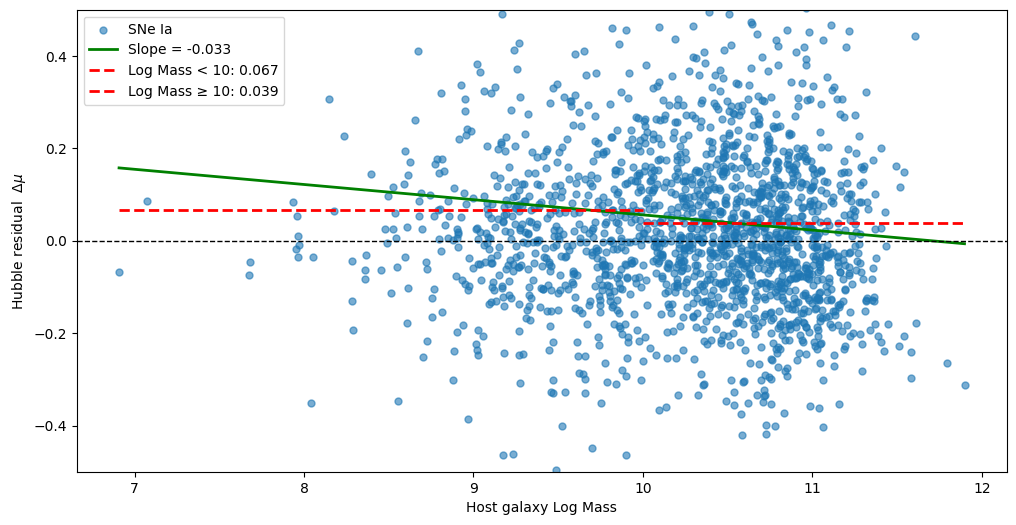


=== Pearson Correlation Test ===
Pearson correlation coefficient (r) = -0.0907
p-value = 1.0635e-04
Correlation strength: very weak or none
Correlation is statistically significant at α=0.05 level


In [15]:
residual_mass = SN_sample["MU"] - np.array(
    [distance_modulus(z, [Omega_m_q50], model="Flat_LCDM") + M_q50 for z in z_data]
)
host_mass = SN_sample["HOSTGAL_LOGMASS"]

coef_mass = np.polyfit(host_mass, residual_mass, 1)
slope_mass, intercept_mass = coef_mass

xfit_mass = np.linspace(host_mass.min(), host_mass.max(), 200)
yfit_mass = slope_mass * xfit_mass + intercept_mass

print(f"Linear trend: Δμ = ({slope_mass:.4f}) × Log Mass + ({intercept_mass:.4f})")

plt.figure(figsize=(12, 6))
plt.scatter(host_mass, residual_mass, s=25, alpha=0.6, label="SNe Ia")
plt.plot(xfit_mass, yfit_mass, color="green", lw=2, label=f"Slope = {slope_mass:.3f}")

# 计算两个质量区间的平均值
mask_low_mass = host_mass < 10
mask_high_mass = host_mass >= 10

mean_low_mass = np.mean(residual_mass[mask_low_mass])
mean_high_mass = np.mean(residual_mass[mask_high_mass])

print(f"Mean Δμ for Log Mass < 10: {mean_low_mass:.4f}")
print(f"Mean Δμ for Log Mass >= 10: {mean_high_mass:.4f}")

# 添加两条平均线
plt.plot([np.min(host_mass), 10], [mean_low_mass, mean_low_mass], 
         color='r', ls='--', lw=2, 
         label=f'Log Mass < 10: {mean_low_mass:.3f}')

plt.plot([10, np.max(host_mass)], [mean_high_mass, mean_high_mass], 
         color='r', ls='--', lw=2, 
         label=f'Log Mass ≥ 10: {mean_high_mass:.3f}')

plt.axhline(0.0, color="k", ls="--", lw=1)
plt.xlabel("Host galaxy Log Mass")
plt.ylabel(r"Hubble residual  $\Delta\mu$")
plt.ylim(-0.5, 0.5)
plt.legend()
plt.show()

pearson_test(host_mass, residual_mass)

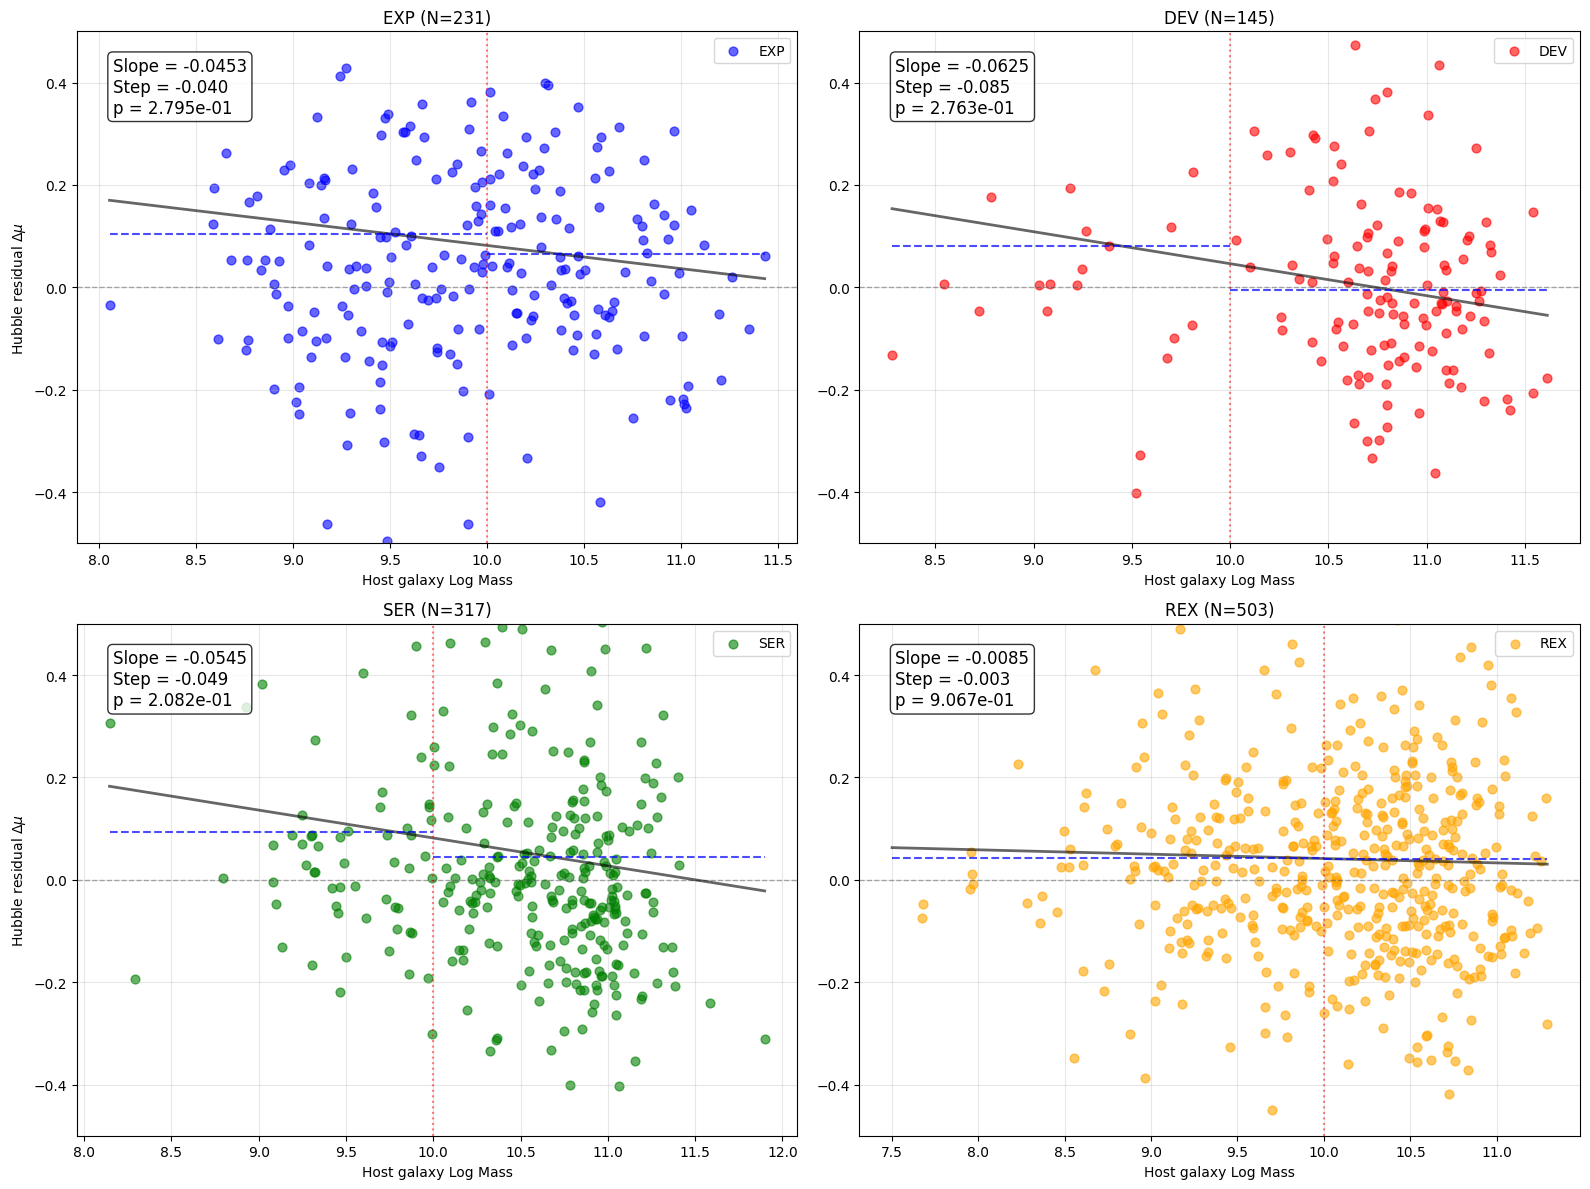


OVERALL PEARSON CORRELATION TEST

=== Pearson Correlation Test ===
Pearson correlation coefficient (r) = -0.0907
p-value = 1.0635e-04
Correlation strength: very weak or none
Correlation is statistically significant at α=0.05 level

PEARSON CORRELATION TESTS BY GALAXY TYPE

EXP (EXP, N=231):
  Pearson r = -0.1036
  p-value = 1.1624e-01
  → Correlation is NOT significant (p ≥ 0.05)

DEV (DEV, N=145):
  Pearson r = -0.1992
  p-value = 1.6301e-02
  → Correlation is significant (p < 0.05)

SER (SER, N=317):
  Pearson r = -0.1111
  p-value = 4.8137e-02
  → Correlation is significant (p < 0.05)

REX (REX, N=503):
  Pearson r = -0.0257
  p-value = 5.6532e-01
  → Correlation is NOT significant (p ≥ 0.05)


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# flat-LCDM
residual_mass = SN_sample["MU"] - np.array(
    [distance_modulus(z, [Omega_m_q50], model="Flat_LCDM") + M_q50 for z in z_data]
)
host_mass = SN_sample["HOSTGAL_LOGMASS"]

type_map = {}
for host in valid_host_galaxies:
    SN_id = host['ID'][0]
    host_type = host['type'][0]
    
    if isinstance(host_type, str):
        host_type = host_type.strip()
    
    type_map[SN_id] = host_type

SN_sample_type = []
for i, sn_id in enumerate(SN_sample['ID']):
    SN_sample_type.append(type_map.get(sn_id, 'UNKNOWN'))

SN_sample_type = np.array(SN_sample_type)

type_colors = {
    'EXP': 'blue',
    'DEV': 'red',
    'SER': 'green',
    'REX': 'orange',
}

type_markers = {
    'EXP': 'o',
    'DEV': 's',
    'SER': '^',
    'REX': 'D',
}

type_labels = {
    'EXP': 'EXP',
    'DEV': 'DEV',
    'SER': 'SER',
    'REX': 'REX',
}

# 按type分类分析
types_to_analyze = ['EXP', 'DEV', 'SER', 'REX']
type_results = {}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, galaxy_type in enumerate(types_to_analyze):
    ax = axes[i]
    
    # 筛选当前类型的星系
    type_mask = SN_sample_type == galaxy_type
    type_mass = host_mass[type_mask]
    type_residual = residual_mass[type_mask]
    
    ax.scatter(type_mass, type_residual, s=40, alpha=0.6,
               color=type_colors[galaxy_type], label=f'{type_labels[galaxy_type]}')
    
    # 线性拟合
    coef = np.polyfit(type_mass, type_residual, 1)
    slope, intercept = coef
    
    xfit = np.linspace(type_mass.min(), type_mass.max(), 200)
    yfit = slope * xfit + intercept
    
    ax.plot(xfit, yfit, 'k-', lw=2, alpha=0.6)
    
    # 计算并绘制质量阶梯
    mask_low = type_mass < 10
    mask_high = type_mass >= 10
    
    if np.sum(mask_low) > 0 and np.sum(mask_high) > 0:
        mean_low = np.mean(type_residual[mask_low])
        mean_high = np.mean(type_residual[mask_high])
        
        # 绘制平均线
        ax.axvline(10, color='red', ls=':', alpha=0.5)
        ax.plot([np.min(type_mass), 10], [mean_low, mean_low], 
                color='blue', ls='--', lw=1.5, alpha=0.7)
        ax.plot([10, np.max(type_mass)], [mean_high, mean_high], 
                color='blue', ls='--', lw=1.5, alpha=0.7)
        
        # 计算统计显著性
        t_stat, p_value = stats.ttest_ind(type_residual[mask_low], 
                                          type_residual[mask_high],
                                          equal_var=False)
        
        # 添加统计信息
        info_text = (f'Slope = {slope:.4f}\n'
                    f'Step = {mean_high-mean_low:.3f}\n'
                    f'p = {p_value:.3e}')
        
        ax.text(0.05, 0.95, info_text, transform=ax.transAxes,
                verticalalignment='top', fontsize=12, 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.axhline(0, color='k', ls='--', lw=1, alpha=0.3)
    ax.set_xlabel('Host galaxy Log Mass')
    if i in [0, 2]:
        ax.set_ylabel(r'Hubble residual $\Delta\mu$')
    ax.set_ylim(-0.5, 0.5)
    ax.set_title(f'{type_labels[galaxy_type]} (N={len(type_mass)})')
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 对整体进行Pearson检验
print("\n" + "="*50)
print("OVERALL PEARSON CORRELATION TEST")
print("="*50)
pearson_test(host_mass, residual_mass)

# 对每种类型分别进行Pearson检验
print("\n" + "="*50)
print("PEARSON CORRELATION TESTS BY GALAXY TYPE")
print("="*50)

for galaxy_type in types_to_analyze:
    type_mask = SN_sample_type == galaxy_type
    if np.sum(type_mask) > 5:
        x_type = host_mass[type_mask]
        y_type = residual_mass[type_mask]
        
        pearson_r, pearson_p = stats.pearsonr(x_type, y_type)
        
        print(f"\n{galaxy_type} ({type_labels[galaxy_type]}, N={len(x_type)}):")
        print(f"  Pearson r = {pearson_r:.4f}")
        print(f"  p-value = {pearson_p:.4e}")
        
        if pearson_p < 0.05:
            print(f"  → Correlation is significant (p < 0.05)")
        else:
            print(f"  → Correlation is NOT significant (p ≥ 0.05)")